In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sat Apr  3 18:56:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 34%   40C    P8    24W / 250W |  10129MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   32C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data
# For poca KDE
from model.collectdata_poca_KDE import collect_data_poca

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mjp_30Mar21 import ACN_1i4_10L_4S_BN_NI as ModelA

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/awkward/__init__.py:23: DeprecationWarning: Consider switching from 'awkward' to 'awkward1', since the new interface will become the default later this year (2020).

    pip install -U awkward1

In Python:

    >>> import awkward1 as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  DeprecationWarning


Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(2)

1 available GPUs (initially using device 0):
  0 TITAN V


/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
# NOTE: to break out of inital training stall, start with Params(128, 20, 5e-5, 0), 
# then transistion to normal training
args = Params(128, 100, 1e-4, 0)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features

## This is used when training with the original KDE
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

'''
## This is used when training with the new KDE
train_loader = collect_data_poca('/share/lazy/will/data/June30_2020_80k_1.h5',
                            '/share/lazy/will/data/June30_2020_80k_3.h5',
                            batch_size=args.batch_size,
                            device=device,
                            masking=True, shuffle=True,
                           ## slice = slice(0,18000)
                           )

val_loader = collect_data_poca('/share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=args.batch_size,
                            device=device,
                            masking=True, shuffle=True,
                            ##slice = slice(18000,None)
                           )
'''

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 13.01 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 12.41 s
Loaded /share/lazy/will/ML_mdsA/June30_2020_80k_1.h5 in 12.16 s
Constructing 240000 event dataset took 6.491 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 3.039 s
Constructing 9984 event dataset took 0.1293 s


"\n## This is used when training with the new KDE\ntrain_loader = collect_data_poca('/share/lazy/will/data/June30_2020_80k_1.h5',\n                            '/share/lazy/will/data/June30_2020_80k_3.h5',\n                            batch_size=args.batch_size,\n                            device=device,\n                            masking=True, shuffle=True,\n                           ## slice = slice(0,18000)\n                           )\n\nval_loader = collect_data_poca('/share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5',\n                            batch_size=args.batch_size,\n                            device=device,\n                            masking=True, shuffle=True,\n                            ##slice = slice(18000,None)\n                           )\n"

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
# Set model to use (defined above)
model = ModelA()

# Prints out layout of each model (keep commented out)
##summary(model, input_size=(4, 4000))
##print(model.parameters)

# Sets save directory for mlflow
mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('Four Feature AllCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


In [9]:
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

# When loading pretrained models, use this code; otherwise, comment it out
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
#pretrained_dict = '/share/lazy/pv-finder_model_repo/12/8b2d0e31296841a89f8c38a2b3b2b655/artifacts/run_stats.pyt'
#load_full_state(model, optimizer, pretrained_dict)

In [10]:
model.to(device)

ACN_1i4_10L_4S_BN_NI(
  (conv1): Conv(
    (0): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.15, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (conv2): Conv(
    (0): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.15, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (conv3): Conv(
    (0): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.15, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (conv4): Conv(
    (0): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


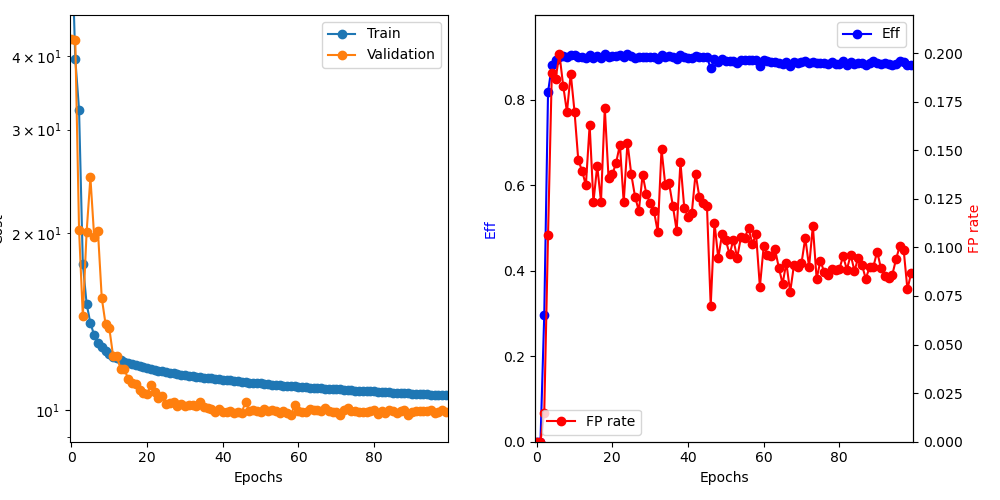

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

for model:  ACN_1i4_10L_4S_BN_NI(
  (conv1): Conv(
    (0): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.15, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (conv2): Conv(
    (0): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.15, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (conv3): Conv(
    (0): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.15, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (conv4): Conv(
    (0): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): D

/home/michael24peters/pv-finder/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 0: train=65.5588, val=42.7179, took 81.174 s
  Validation Found 0 of 54504, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 1: train=39.5987, val=42.658, took 80.85 s
  Validation Found 0 of 54504, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 2: train=32.4474, val=20.2816, took 80.855 s
  Validation Found 16212 of 54504, added 150 (eff 29.74%) (0.015 FP/event)


Epoch 3: train=17.7279, val=14.4465, took 79.55 s
  Validation Found 44577 of 54504, added 1061 (eff 81.79%) (0.106 FP/event)


Epoch 4: train=15.1664, val=20.0932, took 81.771 s
  Validation Found 48015 of 54504, added 1896 (eff 88.09%) (0.19 FP/event)


Epoch 5: train=14.0644, val=24.8759, took 79.089 s
  Validation Found 48643 of 54504, added 1863 (eff 89.25%) (0.187 FP/event)


Epoch 6: train=13.4178, val=19.7103, took 79.044 s
  Validation Found 49082 of 54504, added 1993 (eff 90.05%) (0.2 FP/event)


Epoch 7: train=13.0249, val=20.1325, took 81.362 s
  Validation Found 49179 of 54504, added 1830 (eff 90.23%) (0.183 FP/event)


Epoch 8: train=12.7835, val=15.5266, took 79.089 s
  Validation Found 49054 of 54504, added 1694 (eff 90.00%) (0.17 FP/event)


Epoch 9: train=12.5936, val=14.023, took 81.67 s
  Validation Found 49308 of 54504, added 1891 (eff 90.47%) (0.189 FP/event)


Epoch 10: train=12.4582, val=13.7844, took 79.035 s
  Validation Found 49278 of 54504, added 1696 (eff 90.41%) (0.17 FP/event)


Epoch 11: train=12.3317, val=12.3707, took 81.706 s
  Validation Found 49055 of 54504, added 1445 (eff 90.00%) (0.145 FP/event)


Epoch 12: train=12.2516, val=12.354, took 81.066 s
  Validation Found 49088 of 54504, added 1393 (eff 90.06%) (0.14 FP/event)


Epoch 13: train=12.172, val=11.7383, took 79.423 s
  Validation Found 48972 of 54504, added 1317 (eff 89.85%) (0.132 FP/event)


Epoch 14: train=12.0989, val=11.7549, took 81.037 s
  Validation Found 49331 of 54504, added 1627 (eff 90.51%) (0.163 FP/event)


Epoch 15: train=12.0381, val=11.277, took 79.865 s
  Validation Found 48972 of 54504, added 1232 (eff 89.85%) (0.123 FP/event)


Epoch 16: train=11.9764, val=11.1247, took 79.921 s
  Validation Found 49206 of 54504, added 1417 (eff 90.28%) (0.142 FP/event)


Epoch 17: train=11.9294, val=11.0645, took 81.054 s
  Validation Found 48928 of 54504, added 1234 (eff 89.77%) (0.124 FP/event)


Epoch 18: train=11.8824, val=10.8098, took 80.912 s
  Validation Found 49486 of 54504, added 1715 (eff 90.79%) (0.172 FP/event)


Epoch 19: train=11.8332, val=10.6969, took 79.845 s
  Validation Found 49113 of 54504, added 1354 (eff 90.11%) (0.136 FP/event)


Epoch 20: train=11.7941, val=10.6689, took 79.588 s
  Validation Found 49142 of 54504, added 1373 (eff 90.16%) (0.138 FP/event)


Epoch 21: train=11.7496, val=11.0347, took 79.09 s
  Validation Found 49226 of 54504, added 1434 (eff 90.32%) (0.144 FP/event)


Epoch 22: train=11.7055, val=10.7192, took 77.236 s
  Validation Found 49380 of 54504, added 1526 (eff 90.60%) (0.153 FP/event)


Epoch 23: train=11.6725, val=10.4978, took 81.476 s
  Validation Found 49037 of 54504, added 1230 (eff 89.97%) (0.123 FP/event)


Epoch 24: train=11.6374, val=10.5606, took 81.179 s
  Validation Found 49411 of 54504, added 1537 (eff 90.66%) (0.154 FP/event)


Epoch 25: train=11.615, val=10.2647, took 81.834 s
  Validation Found 49228 of 54504, added 1374 (eff 90.32%) (0.138 FP/event)


Epoch 26: train=11.5724, val=10.2821, took 79.101 s
  Validation Found 49009 of 54504, added 1259 (eff 89.92%) (0.126 FP/event)


Epoch 27: train=11.5514, val=10.3379, took 79.146 s
  Validation Found 49029 of 54504, added 1186 (eff 89.95%) (0.119 FP/event)


Epoch 28: train=11.5215, val=10.1708, took 81.837 s
  Validation Found 49086 of 54504, added 1372 (eff 90.06%) (0.137 FP/event)


Epoch 29: train=11.4931, val=10.2518, took 79.152 s
  Validation Found 49140 of 54504, added 1272 (eff 90.16%) (0.127 FP/event)


Epoch 30: train=11.4772, val=10.1815, took 79.09 s
  Validation Found 49085 of 54504, added 1226 (eff 90.06%) (0.123 FP/event)


Epoch 31: train=11.4496, val=10.1957, took 80.46 s
  Validation Found 49028 of 54504, added 1185 (eff 89.95%) (0.119 FP/event)


Epoch 32: train=11.4234, val=10.2203, took 82.076 s
  Validation Found 48834 of 54504, added 1078 (eff 89.60%) (0.108 FP/event)


Epoch 33: train=11.4052, val=10.181, took 79.137 s
  Validation Found 49306 of 54504, added 1503 (eff 90.46%) (0.151 FP/event)


Epoch 34: train=11.3914, val=10.3341, took 79.158 s
  Validation Found 49131 of 54504, added 1318 (eff 90.14%) (0.132 FP/event)


Epoch 35: train=11.3608, val=10.1214, took 81.042 s
  Validation Found 49157 of 54504, added 1327 (eff 90.19%) (0.133 FP/event)


Epoch 36: train=11.3403, val=10.0763, took 81.01 s
  Validation Found 49059 of 54504, added 1211 (eff 90.01%) (0.121 FP/event)


Epoch 37: train=11.3255, val=10.0559, took 80.709 s
  Validation Found 48840 of 54504, added 1084 (eff 89.61%) (0.109 FP/event)


Epoch 38: train=11.3011, val=9.94383, took 81.051 s
  Validation Found 49279 of 54504, added 1436 (eff 90.41%) (0.144 FP/event)


Epoch 39: train=11.2884, val=10.0364, took 79.036 s
  Validation Found 49017 of 54504, added 1203 (eff 89.93%) (0.12 FP/event)


Epoch 40: train=11.2669, val=9.94697, took 81.58 s
  Validation Found 48930 of 54504, added 1156 (eff 89.77%) (0.116 FP/event)


Epoch 41: train=11.2511, val=9.94658, took 81.422 s
  Validation Found 48933 of 54504, added 1175 (eff 89.78%) (0.118 FP/event)


Epoch 42: train=11.2339, val=9.97566, took 80.397 s
  Validation Found 49226 of 54504, added 1378 (eff 90.32%) (0.138 FP/event)


Epoch 43: train=11.2119, val=9.90495, took 81.73 s
  Validation Found 49136 of 54504, added 1257 (eff 90.15%) (0.126 FP/event)


Epoch 44: train=11.2011, val=9.9311, took 80.793 s
  Validation Found 49046 of 54504, added 1229 (eff 89.99%) (0.123 FP/event)


Epoch 45: train=11.1765, val=9.8981, took 79.113 s
  Validation Found 49040 of 54504, added 1213 (eff 89.98%) (0.121 FP/event)


Epoch 46: train=11.16, val=10.3345, took 79.67 s
  Validation Found 47648 of 54504, added 698 (eff 87.42%) (0.0699 FP/event)


Epoch 47: train=11.1441, val=9.98358, took 79.959 s
  Validation Found 48767 of 54504, added 1126 (eff 89.47%) (0.113 FP/event)


Epoch 48: train=11.1339, val=9.9931, took 79.97 s
  Validation Found 48501 of 54504, added 942 (eff 88.99%) (0.0943 FP/event)


Epoch 49: train=11.1138, val=9.95908, took 81.171 s
  Validation Found 48783 of 54504, added 1067 (eff 89.50%) (0.107 FP/event)


Epoch 50: train=11.1057, val=9.93959, took 81.034 s
  Validation Found 48606 of 54504, added 1035 (eff 89.18%) (0.104 FP/event)


Epoch 51: train=11.0865, val=10.0353, took 81.038 s
  Validation Found 48596 of 54504, added 962 (eff 89.16%) (0.0963 FP/event)


Epoch 52: train=11.0733, val=9.97384, took 80.992 s
  Validation Found 48618 of 54504, added 1038 (eff 89.20%) (0.104 FP/event)


Epoch 53: train=11.0523, val=10.0113, took 80.749 s
  Validation Found 48364 of 54504, added 945 (eff 88.73%) (0.0946 FP/event)


Epoch 54: train=11.0397, val=9.95509, took 82.002 s
  Validation Found 48652 of 54504, added 1052 (eff 89.26%) (0.105 FP/event)


Epoch 55: train=11.0257, val=9.90021, took 81.892 s
  Validation Found 48706 of 54504, added 1047 (eff 89.36%) (0.105 FP/event)


Epoch 56: train=11.0103, val=9.97076, took 79.459 s
  Validation Found 48703 of 54504, added 1098 (eff 89.36%) (0.11 FP/event)


Epoch 57: train=11.0064, val=9.88028, took 81.726 s
  Validation Found 48651 of 54504, added 1017 (eff 89.26%) (0.102 FP/event)


Epoch 58: train=10.9844, val=9.82051, took 81.737 s
  Validation Found 48739 of 54504, added 1065 (eff 89.42%) (0.107 FP/event)


Epoch 59: train=10.9796, val=10.1951, took 80.429 s
  Validation Found 47885 of 54504, added 795 (eff 87.86%) (0.0796 FP/event)


Epoch 60: train=10.9695, val=9.9808, took 80.527 s
  Validation Found 48636 of 54504, added 1003 (eff 89.23%) (0.1 FP/event)


Epoch 61: train=10.9502, val=9.91964, took 81.166 s
  Validation Found 48544 of 54504, added 960 (eff 89.07%) (0.0961 FP/event)


Epoch 62: train=10.9428, val=9.933, took 81.446 s
  Validation Found 48476 of 54504, added 952 (eff 88.94%) (0.0953 FP/event)


Epoch 63: train=10.9272, val=10.033, took 81.087 s
  Validation Found 48405 of 54504, added 989 (eff 88.81%) (0.099 FP/event)


Epoch 64: train=10.9147, val=9.99393, took 81.099 s
  Validation Found 48296 of 54504, added 895 (eff 88.61%) (0.0896 FP/event)


Epoch 65: train=10.9037, val=10.0056, took 80.199 s
  Validation Found 48173 of 54504, added 812 (eff 88.38%) (0.0813 FP/event)


Epoch 66: train=10.8921, val=9.95324, took 79.973 s
  Validation Found 48432 of 54504, added 919 (eff 88.86%) (0.092 FP/event)


Epoch 67: train=10.8821, val=10.0899, took 80.062 s
  Validation Found 47947 of 54504, added 769 (eff 87.97%) (0.077 FP/event)


Epoch 68: train=10.8784, val=9.96275, took 79.926 s
  Validation Found 48384 of 54504, added 906 (eff 88.77%) (0.0907 FP/event)


Epoch 69: train=10.8601, val=9.92261, took 79.992 s
  Validation Found 48375 of 54504, added 896 (eff 88.75%) (0.0897 FP/event)


Epoch 70: train=10.8586, val=9.9262, took 79.974 s
  Validation Found 48417 of 54504, added 917 (eff 88.83%) (0.0918 FP/event)


Epoch 71: train=10.8437, val=9.82798, took 81.132 s
  Validation Found 48625 of 54504, added 1048 (eff 89.21%) (0.105 FP/event)


Epoch 72: train=10.8317, val=10.004, took 80.441 s
  Validation Found 48256 of 54504, added 898 (eff 88.54%) (0.0899 FP/event)


Epoch 73: train=10.8251, val=10.0745, took 80.441 s
  Validation Found 48498 of 54504, added 1109 (eff 88.98%) (0.111 FP/event)


Epoch 74: train=10.8167, val=9.95037, took 81.078 s
  Validation Found 48260 of 54504, added 837 (eff 88.54%) (0.0838 FP/event)


Epoch 75: train=10.7994, val=9.97769, took 79.323 s
  Validation Found 48337 of 54504, added 929 (eff 88.69%) (0.093 FP/event)


Epoch 76: train=10.7886, val=9.93, took 81.777 s
  Validation Found 48262 of 54504, added 872 (eff 88.55%) (0.0873 FP/event)


Epoch 77: train=10.7826, val=9.92625, took 81.173 s
  Validation Found 48127 of 54504, added 857 (eff 88.30%) (0.0858 FP/event)


Epoch 78: train=10.7765, val=9.9258, took 82.063 s
  Validation Found 48391 of 54504, added 889 (eff 88.78%) (0.089 FP/event)


Epoch 79: train=10.7652, val=9.97069, took 79.084 s
  Validation Found 48198 of 54504, added 880 (eff 88.43%) (0.0881 FP/event)


Epoch 80: train=10.7593, val=9.99989, took 79.087 s
  Validation Found 48128 of 54504, added 887 (eff 88.30%) (0.0888 FP/event)


Epoch 81: train=10.75, val=9.86485, took 80.67 s
  Validation Found 48504 of 54504, added 953 (eff 88.99%) (0.0954 FP/event)


Epoch 82: train=10.7394, val=9.95825, took 79.091 s
  Validation Found 48112 of 54504, added 884 (eff 88.27%) (0.0885 FP/event)


Epoch 83: train=10.738, val=9.87762, took 81.254 s
  Validation Found 48461 of 54504, added 961 (eff 88.91%) (0.0962 FP/event)


Epoch 84: train=10.7258, val=10.0062, took 81.332 s
  Validation Found 48188 of 54504, added 877 (eff 88.41%) (0.0878 FP/event)


Epoch 85: train=10.7133, val=9.95397, took 81.994 s
  Validation Found 48304 of 54504, added 946 (eff 88.62%) (0.0947 FP/event)


Epoch 86: train=10.7085, val=9.88409, took 81.942 s
  Validation Found 48282 of 54504, added 906 (eff 88.58%) (0.0907 FP/event)


Epoch 87: train=10.7023, val=9.973, took 79.874 s
  Validation Found 48108 of 54504, added 837 (eff 88.27%) (0.0838 FP/event)


Epoch 88: train=10.6929, val=9.99024, took 79.097 s
  Validation Found 48259 of 54504, added 898 (eff 88.54%) (0.0899 FP/event)


Epoch 89: train=10.6826, val=9.83031, took 79.092 s
  Validation Found 48536 of 54504, added 899 (eff 89.05%) (0.09 FP/event)


Epoch 90: train=10.6738, val=9.93032, took 79.041 s
  Validation Found 48314 of 54504, added 977 (eff 88.64%) (0.0978 FP/event)


Epoch 91: train=10.667, val=9.97725, took 79.076 s
  Validation Found 48187 of 54504, added 891 (eff 88.41%) (0.0892 FP/event)


Epoch 92: train=10.6561, val=9.97205, took 79.007 s
  Validation Found 48277 of 54504, added 852 (eff 88.58%) (0.0853 FP/event)


Epoch 93: train=10.6418, val=9.98402, took 79.031 s
  Validation Found 48187 of 54504, added 841 (eff 88.41%) (0.0842 FP/event)


Epoch 94: train=10.6384, val=9.97892, took 79.045 s
  Validation Found 48027 of 54504, added 858 (eff 88.12%) (0.0859 FP/event)


Epoch 95: train=10.6293, val=9.99127, took 81.851 s
  Validation Found 48181 of 54504, added 938 (eff 88.40%) (0.0939 FP/event)


Epoch 96: train=10.6237, val=9.87711, took 79.711 s
  Validation Found 48538 of 54504, added 1008 (eff 89.05%) (0.101 FP/event)


Epoch 97: train=10.615, val=9.91829, took 79.855 s
  Validation Found 48386 of 54504, added 987 (eff 88.78%) (0.0988 FP/event)


Epoch 98: train=10.6141, val=10.0012, took 80.124 s
  Validation Found 48003 of 54504, added 783 (eff 88.07%) (0.0784 FP/event)


Epoch 99: train=10.6009, val=9.94666, took 80.846 s
  Validation Found 48118 of 54504, added 868 (eff 88.28%) (0.0869 FP/event)
Averaging...

Average Eff:  0.8847387347717598
Average FP Rate:  0.09016524787180771



<IPython.core.display.Javascript object>


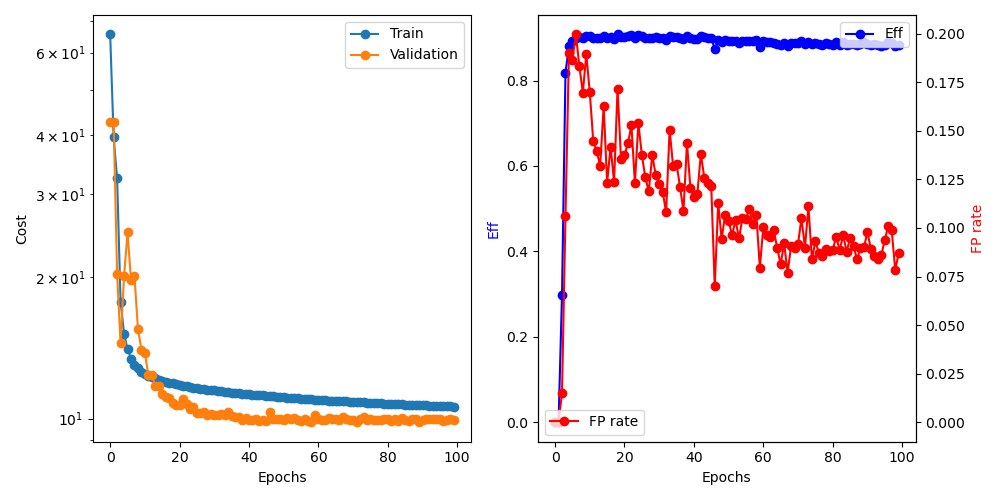

In [12]:
avgEff = 0.0
avgFP = 0.0

print('for model: ', model)   
run_name = 'ACN_1i4_10L_4S_BN_NI (P1)'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
        xs = results.index

        # Update the plot above
        lines['train'].set_data(results.index, results.cost)
        lines['val'].set_data(results.index, results.val)

        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))            
            
        # Redraw the figure
        fig.canvas.draw()
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
        
        # If we are on the last 10 epochs but NOT the last epoch
        if(result['epoch'] >= args.epochs + args.epoch_start - 10):
            avgEff += result['eff_val'].eff_rate
            avgFP += result['eff_val'].fp_rate
           
        # If we are on the last epoch
        if(result['epoch'] == args.epochs + args.epoch_start - 1):
            print('Averaging...\n')
            avgEff /= 10
            avgFP /= 10
            mlflow.log_metric('10 Efficiency Average', avgEff)
            mlflow.log_metric('10 False Positive Average', avgFP)
            print('Average Eff: ', avgEff)
            print('Average FP Rate: ', avgFP)
            
        
        # Log tags
        mlflow.set_tag('Skip connections', '4')
        mlflow.set_tag('Asymmetry', '2.5')
        mlflow.set_tag('KDE_A', 'False')
        mlflow.set_tag('BN Input', 'True')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
    
    # Generate tight plot at end of training
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    plt.tight_layout()
    # Save plot
    plt.savefig('plot.png')  
    mlflow.log_artifact('plot.png')

In [13]:
##quit()

/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
